In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import loguniform
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.utils import resample

# Import Data

In [34]:
df = pd.read_csv('dataset/dataCOMP0050Coursework1.csv')

In [35]:
df.shape

(8929, 21)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8929 entries, 0 to 8928
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             8929 non-null   int64  
 1   term                  8929 non-null   int64  
 2   installment           8929 non-null   float64
 3   emp_length            8504 non-null   float64
 4   home_ownership        8929 non-null   object 
 5   verification_status   8929 non-null   object 
 6   issue_d               8929 non-null   object 
 7   purpose               8929 non-null   object 
 8   dti                   8929 non-null   float64
 9   earliest_cr_line      8929 non-null   int64  
 10  open_acc              8929 non-null   int64  
 11  pub_rec               8929 non-null   int64  
 12  revol_util            8915 non-null   float64
 13  total_acc             8929 non-null   int64  
 14  application_type      8929 non-null   object 
 15  mort_acc             

In [37]:
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,issue_d,purpose,dti,earliest_cr_line,...,pub_rec,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,5675,36,189.56,2.0,RENT,Source Verified,14-Dec,car,15.55,1992,...,0,15.0,15,Individual,0.0,0.0,4.698979,697.0,3.464936,0
1,7000,36,242.63,1.0,RENT,Source Verified,14-Dec,car,6.78,2002,...,0,69.2,5,Individual,0.0,0.0,4.301052,717.0,3.431364,0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,14-Dec,car,10.65,1997,...,0,12.6,35,Individual,2.0,0.0,4.681250,742.0,3.765520,0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,14-Dec,car,21.74,1996,...,0,23.7,22,Individual,4.0,0.0,4.875067,707.0,3.424555,0
4,1500,36,46.31,2.0,OWN,Not Verified,14-Dec,car,12.17,1997,...,0,46.5,13,Individual,2.0,0.0,4.812920,712.0,4.448211,0


In [38]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score',
       'log_revol_bal', 'charged_off'],
      dtype='object')

# Data Analysis

To analysis the staitsical property of features available in the dataset for further feature engineering process.
Sayah (2021) gave a great example to analysis the data of p2p lending data. However, the origianal dataset contains many features that our dataset doesn't have. So subset of his analysis techniques will be reused to support this report. URL: https://www.kaggle.com/faressayah/lending-club-loan-defaulters-prediction

/home/null/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='charged_off', ylabel='count'>

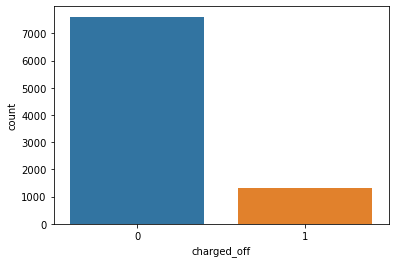

In [39]:
# To see data points grouped by target variable 'charged_off'
sns.countplot(df.charged_off)

In [40]:
df.charged_off.value_counts()

0    7608
1    1321
Name: charged_off, dtype: int64

The analysis shows that data is unblanced with default labelled of 1321 but non-default has 7608 rows. So we need to handle this unbalanced dataset carefully. 

<AxesSubplot:>

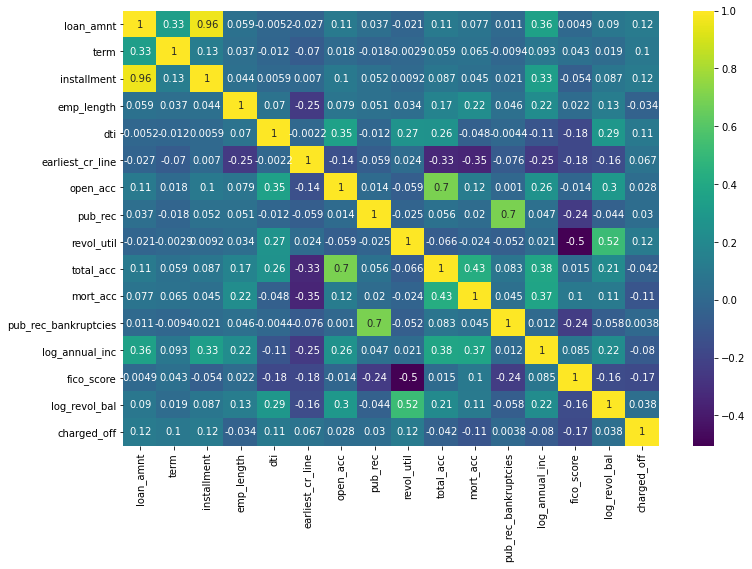

In [41]:
# Plot the installment and loan_amnt features against charged_off variable
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

<AxesSubplot:>

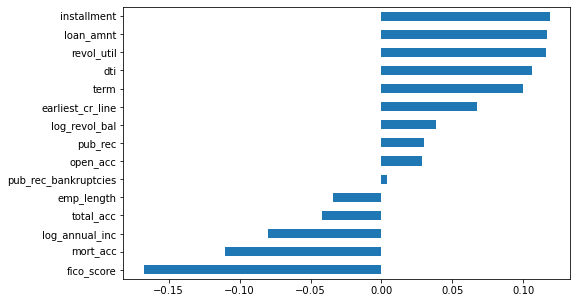

In [42]:
# How numeric features correlate with the target variable?
plt.figure(figsize=(8, 5))
df.corr()['charged_off'].drop('charged_off').sort_values().plot(kind='barh')

The correlation plot shows that there are no features that shows a strong positive or negative correaltion agaist charged_off feature. All features (except charged_off itself) have low correlation value less than 0.5 or -0.5. <br> 
However, there is a strong correation between few training features such as loan_amnt and installment with value of 0.96 which shows (almost) perfect positive correlation. This is an expected relationship as the lender decides the installment corresponding to the loan amount. 

<AxesSubplot:xlabel='charged_off', ylabel='loan_amnt'>

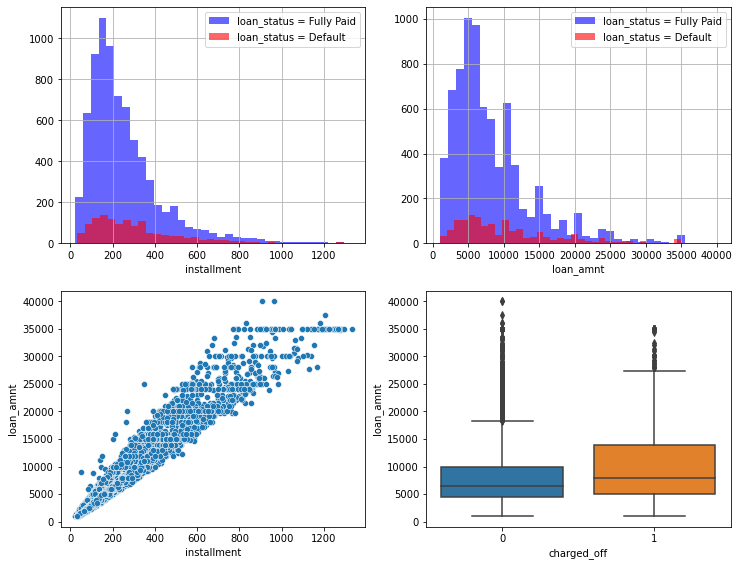

In [43]:
# there is a high correlation (almost perfect) between installment and loan amount
plt.figure(figsize=(12, 20))

plt.subplot(4, 2, 1)
df[df["charged_off"] == 0]["installment"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["installment"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("installment")

plt.subplot(4, 2, 2)
df[df["charged_off"] == 0]["loan_amnt"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["loan_amnt"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("loan_amnt")

plt.subplot(4, 2, 3)
sns.scatterplot(x='installment', y='loan_amnt', data=df)

plt.subplot(4, 2, 4)
sns.boxplot(x='charged_off', y='loan_amnt', data=df)

In [44]:
df.groupby(by='charged_off')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
charged_off,,,,,,,,
0,7608.0,8294.601078,5784.174129,1000.0,4500.0,6500.0,10000.0,40000.0
1,1321.0,10282.021196,7222.812949,1000.0,5000.0,8000.0,14000.0,35000.0


When the lender issue the loan, they always consider the annual income of borrower, length of employments as critical factors.

Text(0.5, 0, 'log_annual_inc')

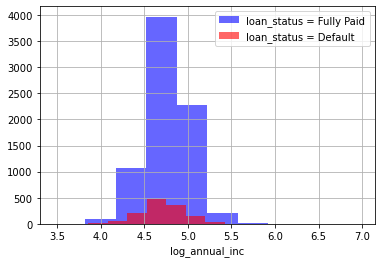

In [45]:
df[df["charged_off"] == 0]["log_annual_inc"].hist(bins=10, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["log_annual_inc"].hist(bins=10, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("log_annual_inc")

Text(0.5, 0, 'emp_length')

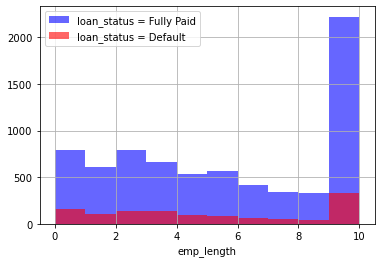

In [46]:
df[df["charged_off"] == 0]["emp_length"].hist(bins=10, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["emp_length"].hist(bins=10, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("emp_length")

In [47]:
df[df.emp_length.isnull()].shape

(425, 21)

Surprisingly, there are 425 rows have null value for emp_length.

Now, lookinng other other numerical attributes that may affect the charged_off prediction

Text(0.5, 0, 'fico_score')

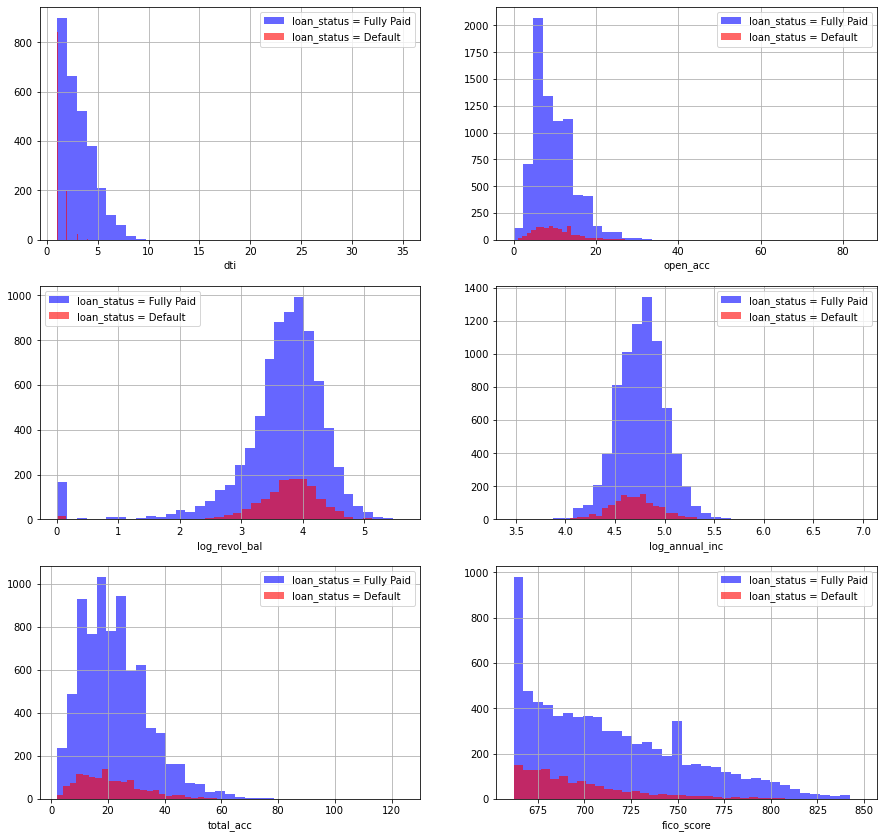

In [48]:
plt.figure(figsize=(15, 30))

plt.subplot(6, 2, 1)
df[df["charged_off"] == 0]["dti"].value_counts().hist(bins=35, color='blue', 
                                                                     label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["dti"].value_counts().hist(bins=35, color='red', 
                                                                      label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("dti")

plt.subplot(6, 2, 2)
df[df["charged_off"] == 0]["open_acc"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["open_acc"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("open_acc")

plt.subplot(6, 2, 3)
df[df["charged_off"] == 0]["log_revol_bal"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["log_revol_bal"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("log_revol_bal")

plt.subplot(6, 2, 4)
df[df["charged_off"] == 0]["log_annual_inc"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["log_annual_inc"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("log_annual_inc")

plt.subplot(6, 2, 5)
df[df["charged_off"] == 0]["total_acc"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["total_acc"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("total_acc")

plt.subplot(6, 2, 6)
df[df["charged_off"] == 0]["fico_score"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["fico_score"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("fico_score")

<AxesSubplot:xlabel='pub_rec_bankruptcies', ylabel='count'>

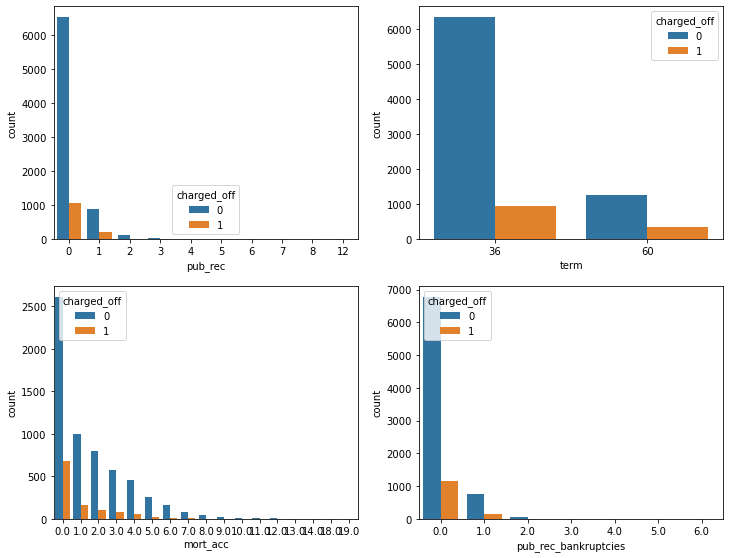

In [49]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=df, hue='charged_off')

plt.subplot(6, 2, 2)
sns.countplot(x='term', data=df, hue='charged_off')

plt.subplot(6, 2, 3)
sns.countplot(x='mort_acc', data=df, hue='charged_off')

plt.subplot(6, 2, 4)
sns.countplot(x='pub_rec_bankruptcies', data=df, hue='charged_off')

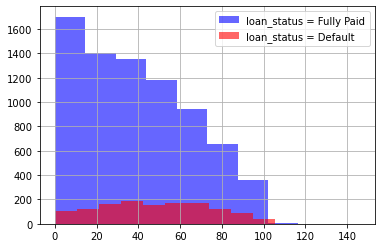

In [50]:
df[df["charged_off"] == 0]["revol_util"].hist(bins=10, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["revol_util"].hist(bins=10, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()

From the previous correlation plot, it doesn't show the correlation of the categorical features. So we should look on the relationship between these features and charged_off variable

In [51]:
# Shows the categorical columns
df.describe(include=['O'])

,home_ownership,verification_status,issue_d,purpose,application_type
count,8929,8929,8929,8929,8929
unique,3,3,120,1,2
top,RENT,Not Verified,14-Oct,car,Individual
freq,4011,4006,269,8929,8908


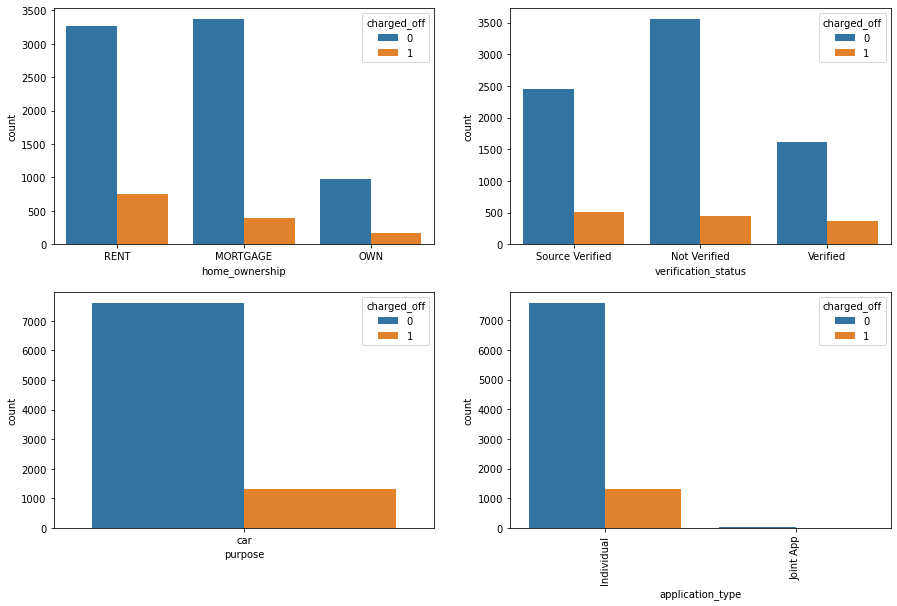

In [52]:
# visualisation of categorical columns (except issue_d)
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='home_ownership', data=df, hue='charged_off')

plt.subplot(4, 2, 2)
sns.countplot(x='verification_status', data=df, hue='charged_off')

plt.subplot(4, 2, 3)
sns.countplot(x='purpose', data=df, hue='charged_off')

plt.subplot(4, 2, 4)
g = sns.countplot(x='application_type', data=df, hue='charged_off')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

Now we notice that the purpose column has only one value of 'car' so we can disregard during feature engineering process.

Issue_d was marked as categorical type as it contains an object of timestamp with month and year. We can visualise the count of fully paid and default loan by extracting year. Similar to earliest_cr_line column which contain numerical value of year. 

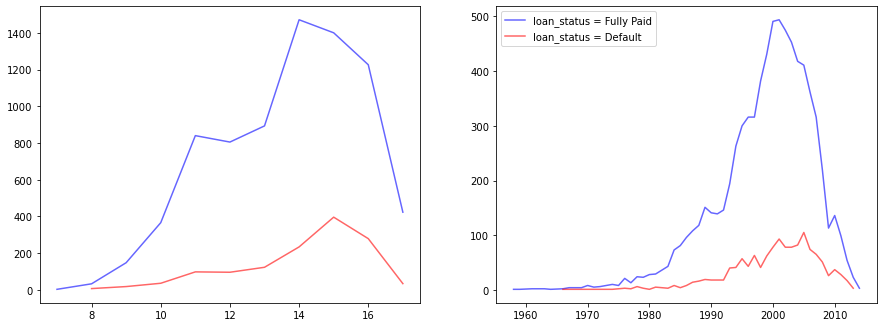

In [53]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
df[df["charged_off"] == 0].issue_d.str.split('-').str[0].astype(int).value_counts().sort_index().plot(color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1].issue_d.str.split('-').str[0].astype(int).value_counts().sort_index().plot(color='red', label='loan_status = Default', alpha=0.6)

plt.subplot(2, 2, 2)
df[df["charged_off"] == 0].earliest_cr_line.value_counts().sort_index().plot(color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1].earliest_cr_line.value_counts().sort_index().plot(color='red', label='loan_status = Default', alpha=0.6)

plt.legend()

There is a peak between 2014 and 2016 that for defaulting loan based on issue_d. However, we should not consider this issue_d into our prediction model because it doesn't give any significant value when we use the model to classify new input with latest issue_d.

Meanwhile, earliest_cr_line should be taken into account as it tell when borrower's earliest reported credit line was opened  

Overall, there are two types of features available for this dataset. There are features that related to applicants such as length of employment and feature of loan characteristics, e.g., total amount of loan. 

# Data Preprocessing

## Missing Data handling

In [54]:
def show_missing(df):
    for column in df.columns:
        if df[column].isnull().sum() != 0:
            total_missing = df[column].isna().sum()
            portion = (total_missing / df.shape[0]) * 100
            print(f"'{column}': number of missing values '{total_missing}' ==> '{portion:.3f}%'")

In [55]:
show_missing(df)

'emp_length': number of missing values '425' ==> '4.760%'
'revol_util': number of missing values '14' ==> '0.157%'
'mort_acc': number of missing values '1756' ==> '19.666%'
'pub_rec_bankruptcies': number of missing values '17' ==> '0.190%'


There are 4 columns with missing values.

In [56]:
# Fill missing emp_length with zero value
df['emp_length'].fillna(0, inplace = True)

To handle mort_acc, we look at the earlier correlation table which shows a positive correlation value of 0.43 with total_acc. To fill missing value, we will use the mean group by total_acc feature.

In [57]:
total_acc_avg = df.groupby(by='total_acc').mean().mort_acc

In [58]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [59]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [60]:
# Check if there is any missing data
df.mort_acc.isnull().sum()

0

revol_util and pub_rec_bankruptcies columns also have missing data. Both columns have missing values which count less than 0.20% of dataset. We can safely remove missing rows from dataset.

In [61]:
show_missing(df)

'revol_util': number of missing values '14' ==> '0.157%'
'pub_rec_bankruptcies': number of missing values '17' ==> '0.190%'


In [62]:
df.dropna(inplace=True)

In [63]:
# Check if there is any column has missing values
df.isnull().sum()

loan_amnt               0
term                    0
installment             0
emp_length              0
home_ownership          0
verification_status     0
issue_d                 0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
log_annual_inc          0
fico_score              0
log_revol_bal           0
charged_off             0
dtype: int64

In [64]:
df.shape

(8898, 21)

The data is reduced to 8898 from 8929 rows

## Categorical data handling

In [65]:
list(df.describe(include=['O']).columns)

['home_ownership',
 'verification_status',
 'issue_d',
 'purpose',
 'application_type']

Every rows has the same purpose 'car' value so we can safely remove this column from the dataset as it will not affect the default loan prediction.

In [66]:
df.purpose.value_counts()

car    8898
Name: purpose, dtype: int64

In [67]:
df.drop('purpose', axis=1, inplace=True)

In [68]:
# number of features remove from 20 to 19 with the same total rows
df.shape

(8898, 20)

As explained previously, we should not consider issue date of loan. This column will be dropped. 

In [69]:
df.drop('issue_d', axis=1, inplace=True)

df.shape

(8898, 19)

In [70]:
# Reset Index of dataFrame
df.reset_index(drop=True, inplace=True)

There are other three categorical features, i.e., home_ownership, verification_status and application_type. There are two techniques can be used to converted text data to numberical value such as LabelEncoder and OneHotEncoder.

In [71]:
# # LabelEncoder - The matrix gives lower value than OneHotEncoder technique
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

# df['home_ownership'] = encoder.fit_transform(df['home_ownership'])
# df['verification_status'] = encoder.fit_transform(df['verification_status'])
# df['application_type'] = encoder.fit_transform(df['application_type'])

In [72]:
# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# verification_status
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['verification_status']]).toarray())

enc_df.columns = ['verification_status_0', 'verification_status_1', 'verification_status_2']
enc_df.head()

df = df.join(enc_df)
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,dti,earliest_cr_line,open_acc,pub_rec,...,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2
0,5675,36,189.56,2.0,RENT,Source Verified,15.55,1992,7,0,...,Individual,0.0,0.0,4.698979,697.0,3.464936,0,0.0,1.0,0.0
1,7000,36,242.63,1.0,RENT,Source Verified,6.78,2002,3,0,...,Individual,0.0,0.0,4.301052,717.0,3.431364,0,0.0,1.0,0.0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,10.65,1997,16,0,...,Individual,2.0,0.0,4.681250,742.0,3.765520,0,1.0,0.0,0.0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,21.74,1996,7,0,...,Individual,4.0,0.0,4.875067,707.0,3.424555,0,1.0,0.0,0.0
4,1500,36,46.31,2.0,OWN,Not Verified,12.17,1997,8,0,...,Individual,2.0,0.0,4.812920,712.0,4.448211,0,1.0,0.0,0.0


In [73]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['home_ownership']]).toarray())

# home_ownership
enc_df.columns = ['home_ownership_0', 'home_ownership_1', 'home_ownership_2']
enc_df.head()

df = df.join(enc_df)
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,dti,earliest_cr_line,open_acc,pub_rec,...,log_annual_inc,fico_score,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2,home_ownership_0,home_ownership_1,home_ownership_2
0,5675,36,189.56,2.0,RENT,Source Verified,15.55,1992,7,0,...,4.698979,697.0,3.464936,0,0.0,1.0,0.0,0.0,0.0,1.0
1,7000,36,242.63,1.0,RENT,Source Verified,6.78,2002,3,0,...,4.301052,717.0,3.431364,0,0.0,1.0,0.0,0.0,0.0,1.0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,10.65,1997,16,0,...,4.681250,742.0,3.765520,0,1.0,0.0,0.0,1.0,0.0,0.0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,21.74,1996,7,0,...,4.875067,707.0,3.424555,0,1.0,0.0,0.0,1.0,0.0,0.0
4,1500,36,46.31,2.0,OWN,Not Verified,12.17,1997,8,0,...,4.812920,712.0,4.448211,0,1.0,0.0,0.0,0.0,1.0,0.0


In [74]:
enc = OneHotEncoder ()
enc_df = pd.DataFrame(enc.fit_transform(df[['application_type']]).toarray())

#application_type
enc_df.columns = ['application_type_0', 'application_type_1']
enc_df.head()

df = df.join(enc_df)
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,dti,earliest_cr_line,open_acc,pub_rec,...,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2,home_ownership_0,home_ownership_1,home_ownership_2,application_type_0,application_type_1
0,5675,36,189.56,2.0,RENT,Source Verified,15.55,1992,7,0,...,3.464936,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,7000,36,242.63,1.0,RENT,Source Verified,6.78,2002,3,0,...,3.431364,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,10.65,1997,16,0,...,3.765520,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,21.74,1996,7,0,...,3.424555,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1500,36,46.31,2.0,OWN,Not Verified,12.17,1997,8,0,...,4.448211,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [75]:
# Drop the original categorical columns
categorical_columns = list(df.describe(include=['O']).columns) 
df.drop(categorical_columns, axis=1, inplace=True)

In [76]:
# Reset Index of dataFrame
df.reset_index(drop=True, inplace=True)

In [77]:
df.head()

,loan_amnt,term,installment,emp_length,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,...,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2,home_ownership_0,home_ownership_1,home_ownership_2,application_type_0,application_type_1
0,5675,36,189.56,2.0,15.55,1992,7,0,15.0,15,...,3.464936,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,7000,36,242.63,1.0,6.78,2002,3,0,69.2,5,...,3.431364,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3500,36,116.24,10.0,10.65,1997,16,0,12.6,35,...,3.765520,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000,36,316.47,10.0,21.74,1996,7,0,23.7,22,...,3.424555,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1500,36,46.31,2.0,12.17,1997,8,0,46.5,13,...,4.448211,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [78]:
df.shape

(8898, 24)

## Duplicate Data

In [79]:
print(f"Data shape: {df.shape}")

# Remove duplicate Features
df = df.T.drop_duplicates()
df = df.T

# Remove Duplicate Rows
df.drop_duplicates(inplace=True)

print(f"Data shape: {df.shape}")

Data shape: (8898, 24)
Data shape: (8898, 24)


There is no duplicate datat points

# Unbalanced Dataset With Random Forest

Now we want to apply simple random forest model to see the performance of defaulting classification on unbalanced dataset.

In [48]:
non_default_prop = df.charged_off.value_counts()[0] / df.shape[0]
default_prop = df.charged_off.value_counts()[1] / df.shape[0]

print(f"Non-Defaulting {non_default_prop}")
print(f"Defaulting {default_prop}")

Non-Defaulting 0.8522139806698135
Defaulting 0.14778601933018656


In [49]:
X = df.drop('charged_off', axis=1)
y = df.charged_off

#Train 90% and Test 10% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8008, 23)
(890, 23)
(8008,)
(890,)


In [50]:
# Normalise the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [51]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [52]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        print("_______________________________________________")
        print(f"AUC: \n {roc_auc_score(true, pred)}\n")
        print(f"Accuracy: \n {accuracy_score(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        print("_______________________________________________")
        print(f"AUC: \n {roc_auc_score(true, pred)}\n")
        print(f"Accuracy: \n {accuracy_score(true, pred)}\n")

In [53]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy    macro avg  weighted avg
precision     0.999853     1.000000  0.999875     0.999927      0.999875
recall        1.000000     0.999167  0.999875     0.999583      0.999875
f1-score      0.999927     0.999583  0.999875     0.999755      0.999875
support    6808.000000  1200.000000  0.999875  8008.000000   8008.000000
_______________________________________________
Confusion Matrix: 
 [[6808    0]
 [   1 1199]]

_______________________________________________
AUC: 
 0.9995833333333333

Accuracy: 
 0.9998751248751249

Test Result:
Classification Report:
                  0.0    1.0  accuracy   macro avg  weighted avg
precision    0.870641    0.0  0.869663    0.435321      0.758143
recall       0.998710    0.0  0.869663    0.499355      0.869663
f1-score     0.930288    0.0  0.869663    0.465144      0.810083
support    775.000000  115.0  0.869663  890.000000    890.000000
__________________________________

# Balanced Dataset

The above result shows that the model underperform on unbalanced dataset as expected. So we need to balance training dataset before feeding to classification model. There are various technique can be used. One is the oversampling techniques, using Boyle's code (2019). URL: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18 . There are other techniques such as unsampling and generating synthetic samples but they don't give better  performance than oversampling technique.

In [126]:
X = df.drop('charged_off', axis=1)
y = df.charged_off

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

In [127]:
y_train.value_counts()

0.0    6808
1.0    1200
Name: charged_off, dtype: int64

In [128]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=0, sampling_strategy=1.0)
# X_train, y_train = sm.fit_sample(X_train, y_train)
# y_train.value_counts()

In [129]:
# Combine training dataset with target variable 'charged_off' from y_train
train = pd.concat([X_train, y_train], axis=1)

non_default = train[train.charged_off==0]
default = train[train.charged_off==1]

# upsample minority to match the number of majority class (non_default)
default_upsampled = resample(default,
                          replace=True, 
                          n_samples=len(non_default),
                          random_state=0) 

# combine non_default and upsampled default
upsampled = pd.concat([non_default, default_upsampled])

print(upsampled.charged_off.value_counts())

# separate to X and y of training dataset
X_train = upsampled.drop('charged_off', axis=1)
y_train = upsampled.charged_off

1.0    6808
0.0    6808
Name: charged_off, dtype: int64


In [130]:
# Normalise data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [57]:
## Without grid search
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
              0.0     1.0  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    6808.0  6808.0       1.0    13616.0       13616.0
_______________________________________________
Confusion Matrix: 
 [[6808    0]
 [   0 6808]]

_______________________________________________
AUC: 
 1.0

Accuracy: 
 1.0

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.881200    0.521739   0.87191    0.701469      0.834752
recall       0.985806    0.104348   0.87191    0.545077      0.871910
f1-score     0.930572    0.173913   0.87191    0.552243      0.832802
support    775.000000  115.000000   0.87191  890.000000    890.000000
_______________________________________________
Confusion Matrix: 
 [[764  11]
 [103  12]]

_______

# Logistic Regression

In [58]:
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

search = RandomizedSearchCV(model, space, n_iter=1000, scoring='f1', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6713522481494363
Best Hyperparameters: {'C': 2.494810169511268, 'penalty': 'l1', 'solver': 'liblinear'}


In [59]:
best_estimator = result.best_estimator_
best_C = result.best_params_['C']
best_penalty = result.best_params_['penalty']
best_solver = result.best_params_['solver']

In [60]:
logreg = LogisticRegression(C = best_C, penalty = best_penalty, solver = best_solver)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [61]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.673295     0.660073  0.666422      0.666684      0.666684
recall        0.646592     0.686251  0.666422      0.666422      0.666422
f1-score      0.659673     0.672908  0.666422      0.666291      0.666291
support    6808.000000  6808.000000  0.666422  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4402 2406]
 [2136 4672]]

_______________________________________________
AUC: 
 0.6664218566392479

Accuracy: 
 0.6664218566392479

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.930712    0.219101  0.646067    0.574906      0.838762
recall       0.641290    0.678261  0.646067    0.659776      0.646067
f1-score     0.759358    0.331210  0.646067    0.545284      0.704036
support    775.000000  115.000000  0.646067  890.000000    890.000000
____

In [62]:
# change of threshold from 0.5 to another threshold
threshold = 0.45

logreg = LogisticRegression(C = best_C, penalty = best_penalty, solver = best_solver)
logreg.fit(X_train, y_train)
predicted_proba = logreg.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

print_score(y_train, y_train_pred, train=True)
print_score(y_test, predicted, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.673295     0.660073  0.666422      0.666684      0.666684
recall        0.646592     0.686251  0.666422      0.666422      0.666422
f1-score      0.659673     0.672908  0.666422      0.666291      0.666291
support    6808.000000  6808.000000  0.666422  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4402 2406]
 [2136 4672]]

_______________________________________________
AUC: 
 0.6664218566392479

Accuracy: 
 0.6664218566392479

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.939732    0.199095   0.57191    0.569414      0.844032
recall       0.543226    0.765217   0.57191    0.654222      0.571910
f1-score     0.688471    0.315978   0.57191    0.502225      0.640340
support    775.000000  115.000000   0.57191  890.000000    890.000000
____

# Decision Tree

In [63]:
model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict({
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 5)
})

search = RandomizedSearchCV(model, space, n_iter=1000, scoring='f1', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/null/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 648 is smaller than n_iter=1000. Running 648 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.7522727567965203
Best Hyperparameters: {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'gini'}


In [64]:
best_estimator = result.best_estimator_
best_min_samples_split = result.best_params_['min_samples_split']
best_min_samples_leaf = result.best_params_['min_samples_leaf']
best_max_depth = result.best_params_['max_depth']
best_criterion = result.best_params_['criterion']

In [65]:
decision_tree = DecisionTreeClassifier(criterion=best_criterion, max_depth = best_max_depth, min_samples_leaf= best_min_samples_leaf, min_samples_split= best_min_samples_split)
decision_tree.fit(X_train, y_train)

y_train_pred = decision_tree.predict(X_train)
y_pred = decision_tree.predict(X_test)

In [66]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.800551     0.749194  0.772474      0.774872      0.774872
recall        0.725764     0.819183  0.772474      0.772474      0.772474
f1-score      0.761325     0.782627  0.772474      0.771976      0.771976
support    6808.000000  6808.000000  0.772474  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4941 1867]
 [1231 5577]]

_______________________________________________
AUC: 
 0.7724735605170387

Accuracy: 
 0.7724735605170387

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.911032    0.198171  0.648315    0.554601      0.818921
recall       0.660645    0.565217  0.648315    0.612931      0.648315
f1-score     0.765894    0.293454  0.648315    0.529674      0.704848
support    775.000000  115.000000  0.648315  890.000000    890.000000
____

# Random Forest

In [67]:
model = RandomForestClassifier()

n_estimators = [100, 500, 1000]
max_depth = [3, 5, 8]
max_features = ["sqrt", 0.5]
space = dict(
    n_estimators = n_estimators,
    max_depth = max_depth,  
    max_features = max_features
)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8082261975968469
Best Hyperparameters: {'max_depth': 8, 'max_features': 0.5, 'n_estimators': 1000}


In [68]:
best_estimator = result.best_estimator_
best_n_estimators = result.best_params_['n_estimators']
best_max_depth = result.best_params_['max_depth']
best_max_features = result.best_params_['max_features']

In [69]:
random_forest = RandomForestClassifier(
    n_estimators = best_n_estimators,
    class_weight='balanced_subsample',
    max_depth = best_max_depth,
    max_features = best_max_features
)
random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_pred = random_forest.predict(X_test)

In [70]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.873106     0.806339  0.836442      0.839723      0.839723
recall        0.787309     0.885576  0.836442      0.836442      0.836442
f1-score      0.827991     0.844102  0.836442      0.836047      0.836047
support    6808.000000  6808.000000  0.836442  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[5360 1448]
 [ 779 6029]]

_______________________________________________
AUC: 
 0.8364424206815512

Accuracy: 
 0.8364424206815512

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.914100    0.227106  0.703371    0.570603      0.825332
recall       0.727742    0.539130  0.703371    0.633436      0.703371
f1-score     0.810345    0.319588  0.703371    0.564966      0.746932
support    775.000000  115.000000  0.703371  890.000000    890.000000
____

# SVM

In [71]:
model = svm.SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
space = dict(kernel=kernel,C=C,gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7365965898935435
Best Hyperparameters: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}


In [72]:
best_estimator = result.best_estimator_
best_C = result.best_params_['C']
best_gamma = result.best_params_['gamma']
best_kernel = result.best_params_['kernel']

In [102]:
clf = svm.SVC(C = best_C, gamma = best_gamma, kernel = best_kernel, probability=True)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

In [103]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.780124     0.741151   0.75918      0.760637      0.760637
recall        0.721798     0.796563   0.75918      0.759180      0.759180
f1-score      0.749828     0.767858   0.75918      0.758843      0.758843
support    6808.000000  6808.000000   0.75918  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4914 1894]
 [1385 5423]]

_______________________________________________
AUC: 
 0.7591803760282021

Accuracy: 
 0.7591803760282021

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.927119    0.240000  0.695506    0.583559      0.838334
recall       0.705806    0.626087  0.695506    0.665947      0.695506
f1-score     0.801465    0.346988  0.695506    0.574227      0.742741
support    775.000000  115.000000  0.695506  890.000000    890.000000
____

In [ ]:
# def plot_auc_roc(y_test, y_pred):
#     roc_auc = roc_auc_score(y_test, y_pred)
#     fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
#     plt.figure()
#     plt.plot(fpr, tpr, label='SVM(area = %0.2f)' % roc_auc)
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic')
#     plt.legend(loc="lower right")
#     plt.savefig('Log_ROC')
#     plt.show()

# plot_auc_roc(y_test, y_pred)

<Figure size 1440x720 with 0 Axes>

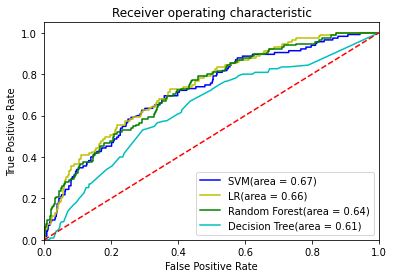

In [112]:
# Plot AUC of all models - SVM, Logistics Regression, 
plt.figure(figsize=(20, 10))

# SVM
# {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
model = svm.SVC(C = 50, gamma = 'scale', kernel = 'rbf', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM(area = %0.2f)' % roc_auc, color='b')


# Logistics Regression
# {'C': 2.494810169511268, 'penalty': 'l1', 'solver': 'liblinear'}
logreg = LogisticRegression(C = 2.494810169511268, penalty = 'l1', solver = 'liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='LR(area = %0.2f)' % roc_auc, color='y')


# Random Forest
# {'max_depth': 8, 'max_features': 0.5, 'n_estimators': 1000}
random_forest = RandomForestClassifier(
    n_estimators = 1000,
    class_weight='balanced_subsample',
    max_depth = 8,
    max_features = 0.5
)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, random_forest.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Random Forest(area = %0.2f)' % roc_auc, color='g')


# Decision Tree
# {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'gini'}
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth = 9, min_samples_leaf= 1, min_samples_split= 3)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, decision_tree.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Decision Tree(area = %0.2f)' % roc_auc, color='c')


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Feature Importance

Finding feature importance of Logistic Regression and Random Forest models. URL: https://machinelearningmastery.com/calculate-feature-importance-with-python/

Feature importance of SVM with linear kernel. URL: https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

In [131]:
model = LogisticRegression()
model.fit(X_train, y_train)
importance = model.coef_[0]
relative_impotance = []
#relative importance
for i,v in enumerate(importance):
    score = 100.0 * (v / max(importance))
    relative_impotance.append(score)
    print('Feature: %0d, Score: %.5f' % (i,score))

Feature: 0, Score: -12.07233
Feature: 1, Score: 27.44237
Feature: 2, Score: 93.96223
Feature: 3, Score: -6.80131
Feature: 4, Score: 62.82376
Feature: 5, Score: -1.57863
Feature: 6, Score: 100.00000
Feature: 7, Score: 39.10170
Feature: 8, Score: 30.41046
Feature: 9, Score: -42.04612
Feature: 10, Score: -37.75751
Feature: 11, Score: -40.80970
Feature: 12, Score: -135.28086
Feature: 13, Score: -65.73351
Feature: 14, Score: -6.84151
Feature: 15, Score: -5.43771
Feature: 16, Score: 2.74548
Feature: 17, Score: 3.94824
Feature: 18, Score: -4.80746
Feature: 19, Score: 0.09139
Feature: 20, Score: 5.97209
Feature: 21, Score: 26.30865
Feature: 22, Score: -25.05263


/home/null/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


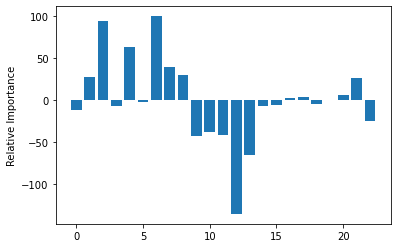

In [132]:
plt.bar([x for x in range(len(relative_impotance))], relative_impotance)
plt.ylabel('Relative Importance')
plt.show()

In [133]:
importance_dict = {X.columns[i]: relative_impotance[i] for i in range(len(relative_impotance))} 
sorted_importance = pd.DataFrame(sorted(importance_dict.items(), key=lambda kv: kv[1], reverse=True)[:15])
sorted_importance.columns = ['feature_name', 'relative_importance']

<Figure size 2160x2160 with 0 Axes>

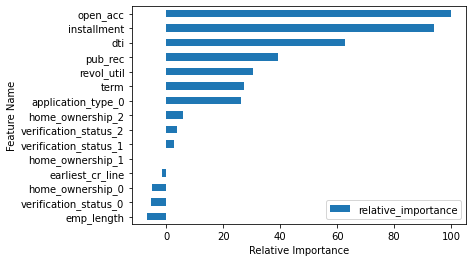

In [134]:
plt.figure(figsize=(30, 30))
sorted_importance.sort_values('relative_importance', inplace=True)
sorted_importance.plot(kind='barh',y='relative_importance',x='feature_name')
plt.ylabel('Feature Name')
plt.xlabel('Relative Importance')
plt.show()

Feature: 0, Score: 80.67820
Feature: 1, Score: 16.98770
Feature: 2, Score: 95.32586
Feature: 3, Score: 48.47613
Feature: 4, Score: 96.46883
Feature: 5, Score: 71.88795
Feature: 6, Score: 61.42658
Feature: 7, Score: 11.44560
Feature: 8, Score: 100.00000
Feature: 9, Score: 70.58444
Feature: 10, Score: 36.71334
Feature: 11, Score: 9.03957
Feature: 12, Score: 92.09302
Feature: 13, Score: 93.39397
Feature: 14, Score: 86.98966
Feature: 15, Score: 15.20913
Feature: 16, Score: 9.78676
Feature: 17, Score: 9.58936
Feature: 18, Score: 11.47760
Feature: 19, Score: 7.25100
Feature: 20, Score: 11.49765
Feature: 21, Score: 0.21691
Feature: 22, Score: 0.18785


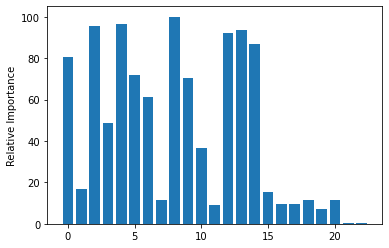

In [135]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

importance = model.feature_importances_
relative_impotance = []
#relative importance
for i,v in enumerate(importance):
    score = 100.0 * (v / max(importance))
    relative_impotance.append(score)
    print('Feature: %0d, Score: %.5f' % (i,score))

plt.bar([x for x in range(len(importance))], relative_impotance)
plt.ylabel('Relative Importance')
plt.show()

In [136]:
importance_dict = {X.columns[i]: relative_impotance[i] for i in range(len(relative_impotance))} 
sorted_importance = pd.DataFrame(sorted(importance_dict.items(), key=lambda kv: kv[1], reverse=True)[:15])
sorted_importance.columns = ['feature_name', 'relative_importance']

In [137]:
sorted_importance.head(20)

,feature_name,relative_importance
0,revol_util,100.000000
1,dti,96.468827
2,installment,95.325860
3,fico_score,93.393975
4,log_annual_inc,92.093023
5,log_revol_bal,86.989656
6,loan_amnt,80.678203
7,earliest_cr_line,71.887949
8,total_acc,70.584439
9,open_acc,61.426580


<Figure size 2160x2160 with 0 Axes>

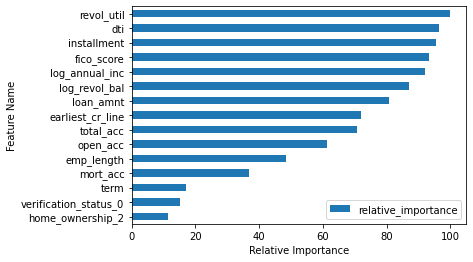

In [138]:
plt.figure(figsize=(30, 30))
sorted_importance.sort_values('relative_importance', inplace=True)
sorted_importance.plot(kind='barh',y='relative_importance',x='feature_name')
plt.ylabel('Feature Name')
plt.xlabel('Relative Importance')
plt.show()

The feature importance only support SVM with kernel 'linear'. The result is disregarded and not going to be included in the report.

In [100]:
model = svm.SVC(kernel='linear')
model.fit(X, y)

importance = model.coef_

Feature: 0, Score: -0.29076
Feature: 1, Score: 44.98127
Feature: 2, Score: 2.86562
Feature: 3, Score: -12.65656
Feature: 4, Score: 29.33670
Feature: 5, Score: 5.80141
Feature: 6, Score: 42.70154
Feature: 7, Score: 85.46249
Feature: 8, Score: 2.17562
Feature: 9, Score: -20.40426
Feature: 10, Score: -33.64560
Feature: 11, Score: -130.85934
Feature: 12, Score: -312.23832
Feature: 13, Score: -12.68659
Feature: 14, Score: -23.99497
Feature: 15, Score: -120.88270
Feature: 16, Score: 100.00000
Feature: 17, Score: 20.88270
Feature: 18, Score: -153.32637
Feature: 19, Score: 61.87346
Feature: 20, Score: 91.45290
Feature: 21, Score: 77.02130
Feature: 22, Score: -77.02130


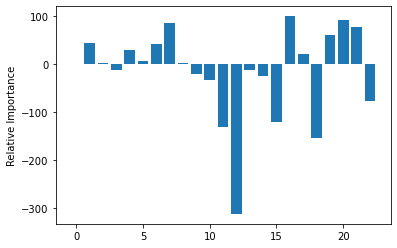

In [101]:
importance = importance[0]
relative_impotance = []
#relative importance
for i,v in enumerate(importance):
    score = 100.0 * (v / max(importance))
    relative_impotance.append(score)
    print('Feature: %0d, Score: %.5f' % (i,score))

plt.bar([x for x in range(len(importance))], relative_impotance)
plt.ylabel('Relative Importance')
plt.show()

In [102]:
importance_dict = {X.columns[i]: relative_impotance[i] for i in range(len(relative_impotance))} 
sorted_importance = pd.DataFrame(sorted(importance_dict.items(), key=lambda kv: kv[1], reverse=True)[:15])
sorted_importance.columns = ['feature_name', 'relative_importance']

In [125]:
sorted_importance

,feature_name,relative_importance
14,verification_status_1,11.325664
13,pub_rec,14.099389
12,term,16.232339
11,mort_acc,31.692647
10,emp_length,48.474377
9,open_acc,65.257092
8,earliest_cr_line,70.534829
7,total_acc,72.491128
6,fico_score,79.067749
5,loan_amnt,80.613371


<Figure size 2160x2160 with 0 Axes>

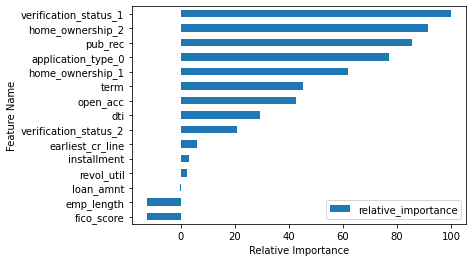

In [103]:
plt.figure(figsize=(30, 30))
sorted_importance.sort_values('relative_importance', inplace=True)
sorted_importance.plot(kind='barh',y='relative_importance',x='feature_name')
plt.ylabel('Feature Name')
plt.xlabel('Relative Importance')
plt.show()

# Feature Selection

In [82]:
# select 3 features of dti, term, and open_acc
X_new = X[['dti', 'term', 'open_acc']]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=0, shuffle=True)

# Combine training dataset with target variable 'charged_off' from y_train
train = pd.concat([X_train, y_train], axis=1)

non_default = train[train.charged_off==0]
default = train[train.charged_off==1]

# upsample minority to match the number of majority class (non_default)
default_upsampled = resample(default,
                          replace=True, 
                          n_samples=len(non_default),
                          random_state=0) 

# combine non_default and upsampled default
upsampled = pd.concat([non_default, default_upsampled])

print(upsampled.charged_off.value_counts())

# separate to X and y of training dataset
X_train = upsampled.drop('charged_off', axis=1)
y_train = upsampled.charged_off

# Normalise data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

1.0    6808
0.0    6808
Name: charged_off, dtype: int64


In [84]:
model = svm.SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
space = dict(kernel=kernel,C=C,gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5388957249865954
Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [85]:
best_estimator = result.best_estimator_
best_C = result.best_params_['C']
best_gamma = result.best_params_['gamma']
best_kernel = result.best_params_['kernel']

In [86]:
clf = svm.SVC(C = best_C, gamma = best_gamma, kernel = best_kernel, probability=True)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

In [87]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.568917     0.602225   0.58233      0.585571      0.585571
recall        0.679642     0.485018   0.58233      0.582330      0.582330
f1-score      0.619370     0.537304   0.58233      0.578337      0.578337
support    6808.000000  6808.000000   0.58233  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4627 2181]
 [3506 3302]]

_______________________________________________
AUC: 
 0.5823296122209165

Accuracy: 
 0.5823296122209166

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.898799    0.182410  0.651685    0.540605      0.806232
recall       0.676129    0.486957  0.651685    0.581543      0.651685
f1-score     0.771723    0.265403  0.651685    0.518563      0.706300
support    775.000000  115.000000  0.651685  890.000000    890.000000
____

No improvement of performance after feature selection

In [88]:
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

search = RandomizedSearchCV(model, space, n_iter=1000, scoring='f1', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6698238316813235
Best Hyperparameters: {'C': 2.041296542554642e-05, 'penalty': 'l2', 'solver': 'liblinear'}


In [89]:
best_estimator = result.best_estimator_
best_C = result.best_params_['C']
best_penalty = result.best_params_['penalty']
best_solver = result.best_params_['solver']

In [90]:
logreg = LogisticRegression(C = best_C, penalty = best_penalty, solver = best_solver)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [91]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.685495     0.521835  0.539072      0.603665      0.603665
recall        0.144389     0.933754  0.539072      0.539072      0.539072
f1-score      0.238534     0.669510  0.539072      0.454022      0.454022
support    6808.000000  6808.000000  0.539072  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[ 983 5825]
 [ 451 6357]]

_______________________________________________
AUC: 
 0.5390716803760283

Accuracy: 
 0.5390716803760282

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.949640    0.143808  0.269663    0.546724      0.845516
recall       0.170323    0.939130  0.269663    0.554727      0.269663
f1-score     0.288840    0.249423  0.269663    0.269131      0.283747
support    775.000000  115.000000  0.269663  890.000000    890.000000
____

No improvement of performance after feature selection

In [92]:
# select 11 for random forest
X_new = X[['dti', 'revol_util', 'installment', 'log_annual_inc', 'log_revol_bal', 'loan_amnt', 'fico_score', 'total_acc', 'earliest_cr_line', 'open_acc', 'emp_length']]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=0, shuffle=True)

# Combine training dataset with target variable 'charged_off' from y_train
train = pd.concat([X_train, y_train], axis=1)

non_default = train[train.charged_off==0]
default = train[train.charged_off==1]

# upsample minority to match the number of majority class (non_default)
default_upsampled = resample(default,
                          replace=True, 
                          n_samples=len(non_default),
                          random_state=0) 

# combine non_default and upsampled default
upsampled = pd.concat([non_default, default_upsampled])

print(upsampled.charged_off.value_counts())

# separate to X and y of training dataset
X_train = upsampled.drop('charged_off', axis=1)
y_train = upsampled.charged_off

# Normalise data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

1.0    6808
0.0    6808
Name: charged_off, dtype: int64


In [94]:
model = RandomForestClassifier()

n_estimators = [100, 500, 1000]
max_depth = [3, 5, 8]
max_features = ["sqrt", 0.5]
space = dict(
    n_estimators = n_estimators,
    max_depth = max_depth,  
    max_features = max_features
)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7946395405760964
Best Hyperparameters: {'max_depth': 8, 'max_features': 0.5, 'n_estimators': 100}


In [95]:
best_estimator = result.best_estimator_
best_n_estimators = result.best_params_['n_estimators']
best_max_depth = result.best_params_['max_depth']
best_max_features = result.best_params_['max_features']

In [96]:
random_forest = RandomForestClassifier(
    n_estimators = best_n_estimators,
    class_weight='balanced',
    max_depth = best_max_depth,
    max_features = best_max_features
)
random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_pred = random_forest.predict(X_test)

In [97]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.854962     0.793002  0.821019      0.823982      0.823982
recall        0.773208     0.868831  0.821019      0.821019      0.821019
f1-score      0.812032     0.829186  0.821019      0.820609      0.820609
support    6808.000000  6808.000000  0.821019  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[5264 1544]
 [ 893 5915]]

_______________________________________________
AUC: 
 0.8210193889541716

Accuracy: 
 0.8210193889541716

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.917329    0.241379  0.719101    0.579354      0.829987
recall       0.744516    0.547826  0.719101    0.646171      0.719101
f1-score     0.821937    0.335106  0.719101    0.578522      0.759032
support    775.000000  115.000000  0.719101  890.000000    890.000000
____

No improvement of performance after feature selection